# Fashion Mnist

Escalar las imágenes en un rango de [0,1]. Usar 10% del conjunto de prueba para validación en el
entrenamiento. Reportar valor de perdida y exactitud para entrenamiento y prueba. Proponer CNN procurando obtener resultados
reportados entre el 85% - 89% de exactitud para el conjunto de prueba

In [2]:
!pip install torchmetrics --quiet

In [3]:
import torchvision.datasets as datasets
from torchvision import transforms

# Normalizamos las imágenes en rango de 0 y 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar dataset y normalizar
fashion_tr = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_te = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
from torch.utils.data import random_split

# Usar 10% del conjunto de prueba para validación en el entrenamiento. 
test_size = len(fashion_te)

validation_size = int(test_size * 0.1)
test_size -= validation_size

fashion_val, fashion_te = random_split(fashion_te, [validation_size, test_size])

print(f"Tamaño del conjunto de entrenamiento: {len(fashion_tr)}")
print(f"Tamaño del conjunto de prueba: {len(fashion_te)}")
print(f"Tamaño del conjunto de validación: {len(fashion_val)}")

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de prueba: 9000
Tamaño del conjunto de validación: 1000


In [5]:
from torch.utils.data import DataLoader

batch_size = 64

train_data = DataLoader(dataset=fashion_tr,
                        batch_size=batch_size,
                        num_workers=2,
                        shuffle=True)

test_data = DataLoader(dataset=fashion_te,
                       batch_size=batch_size,
                       num_workers=2)

val_data = DataLoader(dataset=fashion_val,
                      batch_size=batch_size,
                      num_workers=2)

a. Implemente la CNN omitiendo las capas dropout e implemente EarlyStopping monitoreando la perdida del conjunto de validación y una paciencia de 2.

In [6]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.ZeroPad2d(1),  # Add zero-padding of size 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1),
            nn.ReLU(),
            nn.ZeroPad2d(1),  # Add zero-padding of size 1
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(in_features=12544, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)


model = NeuralNetwork(num_classes=10)
print(model)

NeuralNetwork(
  (network): Sequential(
    (0): ZeroPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ZeroPad2d((1, 1, 1, 1))
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=12544, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): Softmax(dim=1)
  )
)


In [7]:
import torch

def get_device():
    device = ""
    if torch.cuda.is_available():
        !nvidia-smi
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    return device

device = get_device()
device

Mon May  8 15:15:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:00:05.0 Off |                  N/A |
| 30%   28C    P8     8W / 125W |      3MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

device(type='cuda')

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
import numpy as np

from pytorchtools import EarlyStopping
from torchmetrics.classification import Accuracy

def train_early(model, patience, epochs, num_classes):
    train_losses = []
    valid_losses = []

    avg_train_losses = []
    avg_valid_losses = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    model = model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        model.train()
        for batch, (images, labels) in enumerate(train_data):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_losses.append(loss.item())

            if batch % 500 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch+1}/{len(train_data)} | Loss: {running_loss/100:.4f}')
                running_loss = 0.0

        # Validación del model
        model.eval()
        with torch.no_grad():
            for _, (images, labels) in enumerate(val_data):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                accuracy.update(predicted.to('cpu'), labels.to('cpu'))

                running_val_loss += loss.item()
                valid_losses.append(loss.item())

        acc = accuracy.compute()
        print(f"Running Accuracy: {acc}")

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break


    model.load_state_dict(torch.load('checkpoint.pt'))

    print(f"Accuracy promedio: {accuracy.compute()}")

    return model, avg_train_losses, avg_valid_losses

In [10]:
patience = 2
epochs = 10
num_classes = 10

model, train_loss, valid_loss = train_early(model, 
                                      patience, 
                                      epochs, 
                                      num_classes)

Epoch: 1/10 | Batch: 1/938 | Loss: 0.0230
Epoch: 1/10 | Batch: 501/938 | Loss: 8.4651
Running Accuracy: 0.8769999742507935
Epoch: 1/10 | Train Loss: 1.6542 | Valid Loss: 1.5869
Validation loss decreased (inf --> 1.586895).  Saving model ...
Epoch: 2/10 | Batch: 1/938 | Loss: 0.0163
Epoch: 2/10 | Batch: 501/938 | Loss: 7.9128
Running Accuracy: 0.8755000233650208
Epoch: 2/10 | Train Loss: 1.5809 | Valid Loss: 1.5885
EarlyStopping counter: 1 out of 2
Epoch: 3/10 | Batch: 1/938 | Loss: 0.0161
Epoch: 3/10 | Batch: 501/938 | Loss: 7.8279
Running Accuracy: 0.874666690826416
Epoch: 3/10 | Train Loss: 1.5665 | Valid Loss: 1.5878
EarlyStopping counter: 2 out of 2
Early stopping at epoch 3
Accuracy promedio: 0.874666690826416


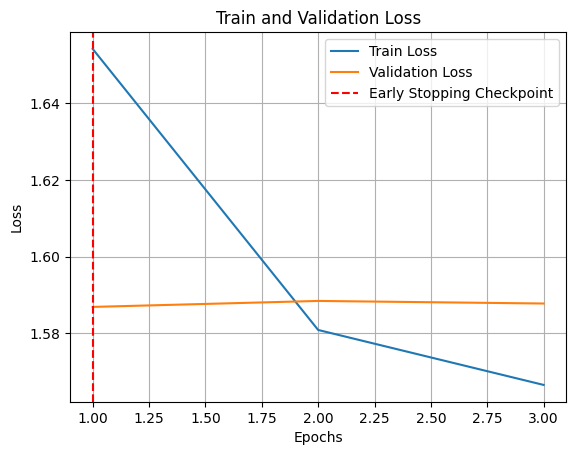

In [11]:
import matplotlib.pyplot as plt

# Generate x-axis values based on the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting the train_loss and valid_loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')

# Find the index of the minimum validation loss
min_valid_loss_idx = valid_loss.index(min(valid_loss))

# Add a vertical line to mark the early stopping checkpoint
plt.axvline(x=min_valid_loss_idx + 1, linestyle='--', color='r', label='Early Stopping Checkpoint')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.grid(True)

# Show legend
plt.legend()

# Display the plot
plt.show()

In [12]:
from torchmetrics.classification import Accuracy


def test(model):
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    with torch.no_grad():
        model.eval()

        for data in test_data:
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            acc = accuracy.forward(predicted.to('cpu'), labels.to('cpu'))

        print(f"Accuracy: {accuracy.compute()}")


test(model)

Accuracy: 0.8665555715560913
